# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.043442,False,0.951002
1,-1.499520,False,-4.136193
2,-0.304240,False,0.278873
3,0.716820,False,0.965639
4,-0.020028,False,0.354954
...,...,...,...
995,-0.696504,False,-2.461603
996,-0.928783,False,-1.393188
997,1.254098,True,7.919285
998,0.113046,False,0.827747


<AxesSubplot:xlabel='v0'>

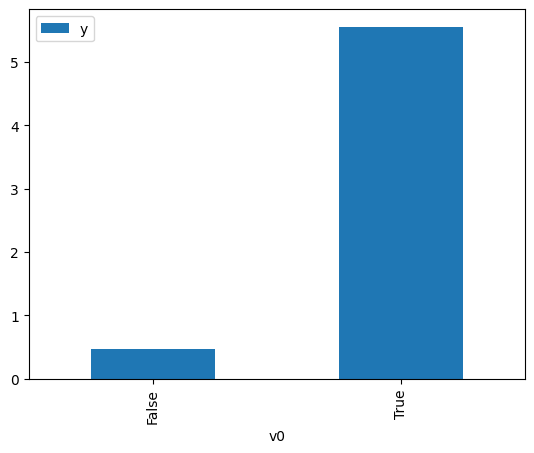

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

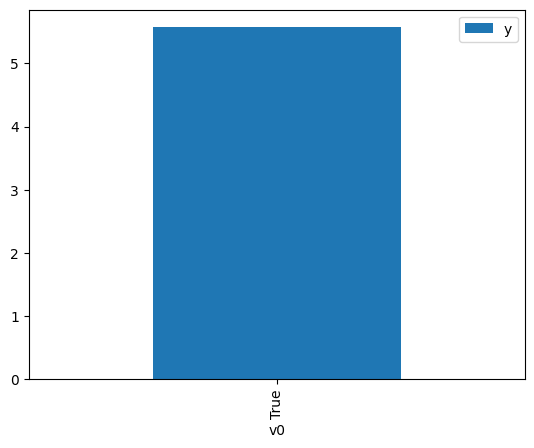

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.560016,False,-3.694463,0.651513,1.534889
1,0.817575,False,0.839890,0.431016,2.320100
2,0.816961,False,0.048199,0.431073,2.319792
3,1.305865,False,3.394389,0.386217,2.589216
4,-0.817016,False,-3.745344,0.585012,1.709368
...,...,...,...,...,...
995,0.076379,False,1.763547,0.500980,1.996086
996,1.173692,False,2.687989,0.398188,2.511374
997,-0.627517,False,-1.268152,0.567431,1.762328
998,3.128447,False,7.014053,0.239439,4.176433


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.744927,True,2.929574,0.421653,2.371616
1,1.004274,True,7.630994,0.586289,1.705643
2,-3.156799,True,-1.359255,0.225758,4.429512
3,1.243691,True,6.012126,0.608168,1.644283
4,0.581280,True,6.807686,0.546843,1.828678
...,...,...,...,...,...
995,-0.758252,True,3.724444,0.420419,2.378578
996,0.829744,True,5.973774,0.570118,1.754024
997,-0.744927,True,2.929574,0.421653,2.371616
998,-0.630831,True,5.016888,0.432260,2.313424


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.023e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        16:51:07   Log-Likelihood:                         -1457.0
No. Observations:                1000   AIC:                                      2918.
Df Residuals:                     998   BIC:                                      2928.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1629      0.035     62.197      0.000       2.095       2.231
x2             5.0062      0.048    104.223      0.000       4.912       5.100
==============================================================================
Omnibus:                        2.050   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.911
Skew:                           0.096   Prob(JB):                        0.385
Kurtosis:                       3.096   Cond. No.                         1.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""